In [1]:
import pypyodbc as odbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# --- Import ALL the models for our "bake-off" ---
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

In [17]:
# -----------------------------
# 1. Load data
# -----------------------------
DRIVER_NAME = 'SQL Server'
SERVER_NAME = 'HIMA'
DATABASE_NAME = 'ITIExaminationSystem'

CONNECTION_STRING = f'DRIVER={{{DRIVER_NAME}}};SERVER={SERVER_NAME};DATABASE={DATABASE_NAME};Trusted_Connection=yes;'
conn = odbc.connect(CONNECTION_STRING)

query = """
SELECT
    s.Student_ID,
    s.Student_Faculty,
    s.Student_Faculty_Grade,
    s.Student_Gender,
    s.Student_Marital_Status,
    b.Branch_Name,
    YEAR(t.intake_start_date) AS "Year", 
    SUM(sea.student_grade) AS total_grade
FROM
    Student AS s
LEFT JOIN
    dbo.[Group] AS g ON g.Group_ID = s.Intake_Branch_Track_ID
LEFT JOIN
    Branch AS b ON b.Branch_ID = g.Branch_ID
LEFT JOIN
    Intake AS t ON t.Intake_ID = g.Intake_ID
INNER JOIN
    Student_Exam_Answer AS sea ON sea.Student_ID = s.Student_ID
INNER JOIN
    exam AS e ON sea.Exam_ID = e.Exam_ID 
WHERE
    e.Exam_Type = 'Normal'
GROUP BY
    s.Student_ID,
    s.Student_Faculty,
    s.Student_Faculty_Grade,
    s.Student_Gender,
    s.Student_ITI_Status,
    s.Student_Marital_Status,
    b.Branch_Name,
    YEAR(t.intake_start_date)
"""
df = pd.read_sql(query, conn)


C:\Users\ibrah\AppData\Local\Temp\ipykernel_20392\3986003973.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [18]:
df.head()

,student_id,student_faculty,student_faculty_grade,student_gender,student_marital_status,branch_name,year,total_grade
0,48375,Faculty of Business Administration,Excellent,Male,Married,El Fayoum,2024,112.0
1,12234,Faculty of Computers Sciences,Excellent,Male,Single,Cairo University,2024,119.0
2,36257,Faculty of Engineering,Good,Female,Single,New Capital,2024,96.0
3,8093,Faculty of Computers Sciences,Good,Male,Married,Aswan,2023,74.0
4,48253,Faculty of Agriculture,Pass,Female,Single,New Capital,2024,84.0


In [19]:
len(set(df.branch_name)) == len(df.branch_name.unique().tolist())

True

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12900 entries, 0 to 12899
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   student_id              12900 non-null  int64  
 1   student_faculty         12900 non-null  object 
 2   student_faculty_grade   12900 non-null  object 
 3   student_gender          12900 non-null  object 
 4   student_marital_status  12900 non-null  object 
 5   branch_name             12900 non-null  object 
 6   year                    12900 non-null  int64  
 7   total_grade             12900 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 806.4+ KB


In [21]:
# -----------------------------
# 2. Data Cleaning & Feature Engineering
# -----------------------------

df['student_faculty_grade'] = df['student_faculty_grade'].map({'Pass': 3, 'Good': 2, 'Very Good': 1, 'Excellent': 0}).astype("int")

# Faculty groups
def faculty_group(faculty):
    stem = ['Faculty of Computers Sciences', 'Faculty of Engineering', 'Faculty of Information Systems', 'Faculty of Science']
    business = ['Faculty of Business Administration', 'Faculty of Commerce', 'Faculty of Economics and Political Science']
    arts = ['Faculty of Fine Arts', 'Faculty of Applied Arts', 'Faculty of Arts']
    applied = ['Faculty of Agriculture', 'Faculty of Education']
    if faculty in stem:
        return 'STEM'
    elif faculty in business:
        return 'Business'
    elif faculty in arts:
        return 'Arts'
    elif faculty in applied:
        return 'Applied'
    else:
        return 'Other'

df['faculty_group'] = df['student_faculty'].apply(faculty_group)


if 'student_id' in df.columns:
    df.drop('student_id',axis=1,inplace=True)
if 'student_faculty' in df.columns:
    df = df.drop('student_faculty', axis=1)
    
# Handle potential missing values (a good safety check)
df.dropna(inplace=True)
df.head()

,student_faculty_grade,student_gender,student_marital_status,branch_name,year,total_grade,faculty_group
0,0,Male,Married,El Fayoum,2024,112.0,Business
1,0,Male,Single,Cairo University,2024,119.0,STEM
2,2,Female,Single,New Capital,2024,96.0,STEM
3,2,Male,Married,Aswan,2023,74.0,STEM
4,3,Female,Single,New Capital,2024,84.0,Applied


In [22]:
# -----------------------------
# 3. Features and Categorical List
# -----------------------------
y = df['total_grade']
X = df.drop('total_grade',axis=1)


numeric_features = ['student_faculty_grade']

categorical_features = ['student_gender', 'student_marital_status', 'faculty_group','branch_name','year']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough')

print("--- Preprocessor built successfully ---")
# --- A: Define the models we want to compare ---
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "LightGBM": lgbm.LGBMRegressor(random_state=42, verbose=-1), # verbose=-1 silences warnings
    "CatBoost": cb.CatBoostRegressor(random_state=42, verbose=0) # verbose=0 silences training logs
}

# --- B: Define our Cross-Validation strategy ---
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']


--- Preprocessor built successfully ---


In [23]:
results_list = []

print(f"--- Starting Benchmark on {len(models)} models ---")

# --- D: Loop through each model and run the test ---
for model_name, model in models.items():
    print(f"Testing {model_name}...")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    scores = cross_validate(pipeline, X, y, cv=kfold, scoring=scoring_metrics)
    
    results_list.append({
        "Model": model_name,
        "Mean R2": scores['test_r2'].mean(),
        "Mean MSE": -scores['test_neg_mean_squared_error'].mean(), 
        "Mean MAE": -scores['test_neg_mean_absolute_error'].mean()
    })

# -----------------------------
# 5. Show Benchmark Results
# -----------------------------
print("\n--- Benchmarking Complete ---")
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by="Mean R2", ascending=False)

print(results_df)

best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 The highest R2 score belongs to: {best_model_name}")
print(f"\n--- Training final model: {best_model_name} ---")

--- Starting Benchmark on 6 models ---
Testing Linear Regression...
Testing Random Forest...
Testing Gradient Boosting...
Testing XGBoost...
Testing LightGBM...


c:\Users\ibrah\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ibrah\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\ibrah\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ibrah\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

Testing CatBoost...

--- Benchmarking Complete ---
               Model   Mean R2   Mean MSE  Mean MAE
2  Gradient Boosting  0.914716  19.857754  3.485882
0  Linear Regression  0.914098  20.001787  3.523987
4           LightGBM  0.913427  20.158592  3.512673
5           CatBoost  0.910067  20.939986  3.584311
3            XGBoost  0.906924  21.669937  3.650147
1      Random Forest  0.900641  23.133359  3.764625

🏆 The highest R2 score belongs to: Gradient Boosting

--- Training final model: Gradient Boosting ---


Final model trained successfully.


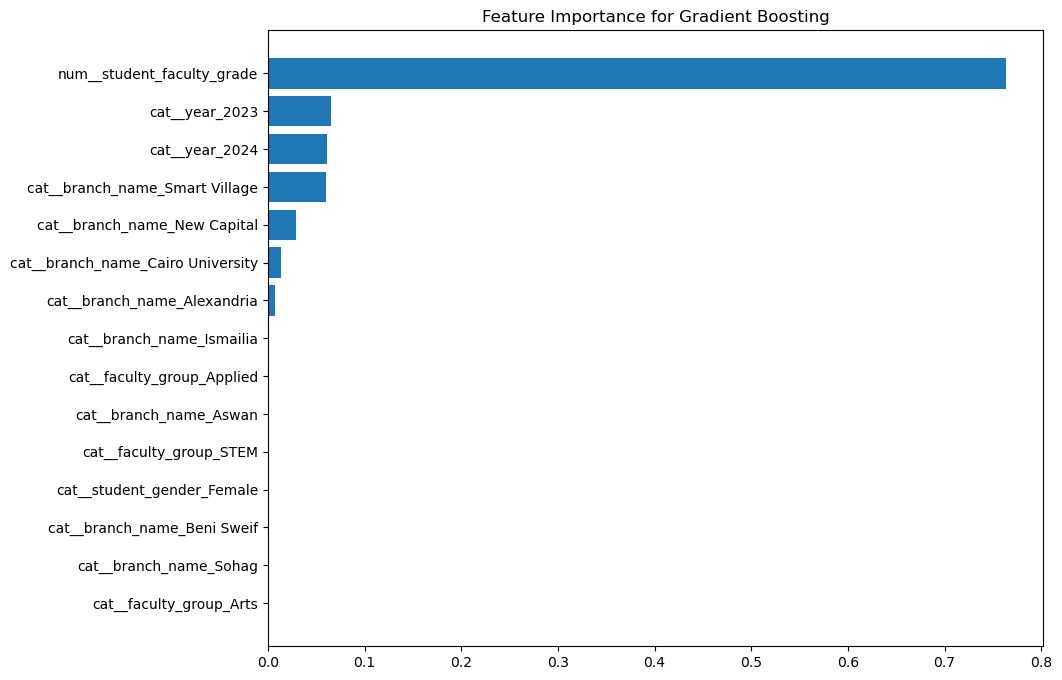

In [24]:
# Get the best model object from our dictionary
best_model_object = models[best_model_name]

# Create the final, production-ready pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model_object)
])

# Train the final pipeline on ALL data
final_pipeline.fit(X, y)
print("Final model trained successfully.")

# -----------------------------
# 7. Plot Feature Importance (as requested)
# -----------------------------

# Get the preprocessor and model steps from the trained pipeline
preprocessor_step = final_pipeline.named_steps['preprocessor']
model_step = final_pipeline.named_steps['regressor']

# Get the final feature names *after* one-hot encoding
try:
    feature_names = preprocessor_step.get_feature_names_out()
except Exception as e:
    print(f"Could not get feature names: {e}. Skipping plot.")
    feature_names = []

if len(feature_names) > 0:
    importances = []
    # Get importances based on model type
    if hasattr(model_step, 'feature_importances_'):
        # For tree-based models (RF, GBM, XGB, LGBM, CatBoost)
        importances = model_step.feature_importances_
        title = f'Feature Importance for {best_model_name}'
    elif hasattr(model_step, 'coef_'):
        # For Linear Regression
        importances = np.abs(model_step.coef_)
        title = f'Coefficient Magnitude for {best_model_name}'
    
    if len(importances) > 0:
        # Create a DataFrame for plotting
        fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        fi_df = fi_df.sort_values(by='Importance', ascending=False).head(15) # Show top 15
        
        
        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(fi_df['Feature'], fi_df['Importance'])
        plt.title(title)
        plt.gca().invert_yaxis() # Show highest importance at the top
        plt.show()
    else:
        print(f"The selected model ({best_model_name}) does not have .feature_importances_ or .coef_.")

In [25]:
# 8. Save Model for Streamlit (as requested)
# -----------------------------
# This saves the ENTIRE pipeline (preprocessor + model)
model_filename = "iti_grade_predictor_pipeline.pkl"
joblib.dump(final_pipeline, model_filename)

print(f"\n✅ Model pipeline saved to {model_filename}")
print("You are now ready to use this file in your Streamlit application!")


✅ Model pipeline saved to iti_grade_predictor_pipeline.pkl
You are now ready to use this file in your Streamlit application!
